# Load

In [1]:
# Import libraries

from pathlib import Path
import os.path
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras import layers,models
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau

2024-04-18 22:55:31.430462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [3]:
# Define the directory where the images are located
image_dir = Path("./dataset")

# Get a list of all jpg image file paths within the directory
filepaths = list(image_dir.glob(r'**/*.jpg'))

# Extract labels (directory names) corresponding to each image
labels = [p.parent.name for p in filepaths]

# Convert filepaths list to a Pandas Series and name the column 'Filepath'
filepaths = pd.Series(filepaths, name='Filepath').astype(str)

# Convert labels list to a Pandas Series and name the column 'Label'
labels = pd.Series(labels, name='Label')

# Concatenate the filepaths and labels to form a dataframe
image_df = pd.concat([filepaths, labels], axis=1)

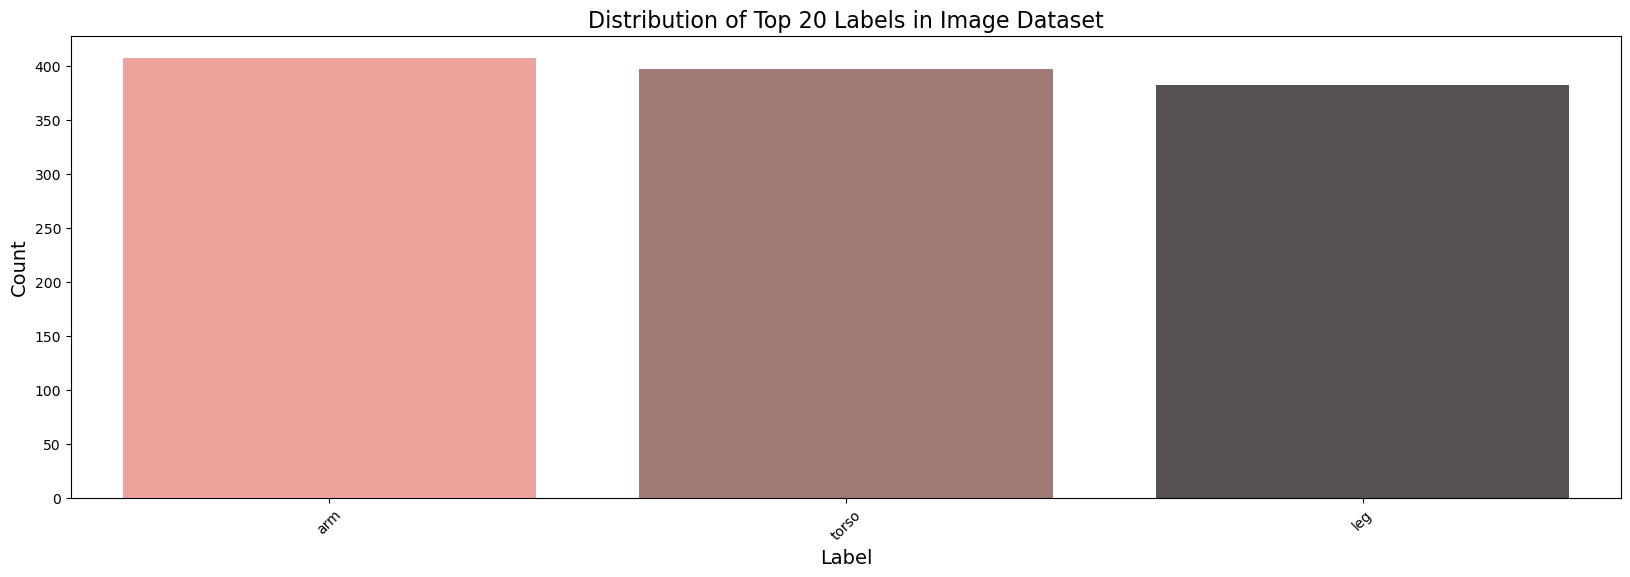

In [4]:
# Count the number of images for each label
label_counts = image_df['Label'].value_counts()

# Plot the distribution of image counts for each label
plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

We have a balanced dataset.

# Preprocess

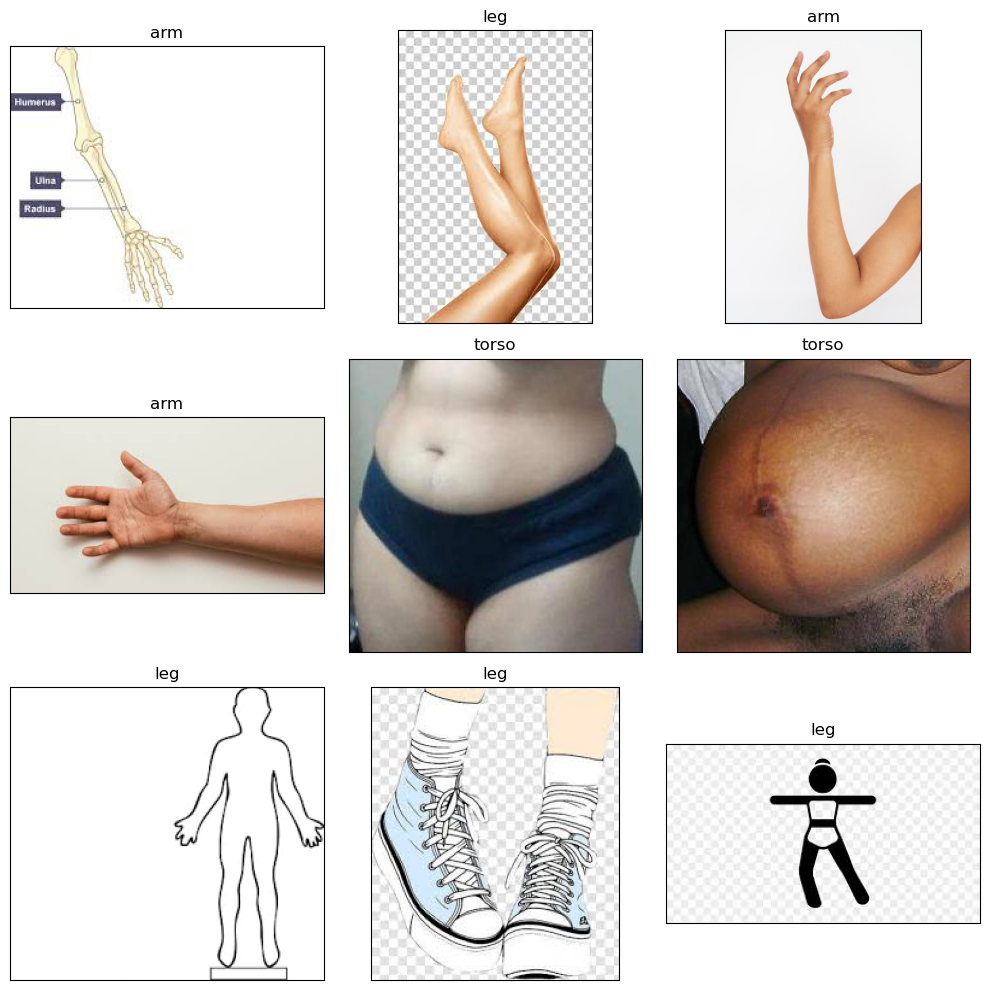

In [5]:
# Display nine random picture from the dataset with their respective labels
random_index = np.random.randint(0, len(image_df), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
# Split dataframe into train and test (we will get validation in the next chunk)
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [7]:
# Create a data generator for training data with a specific preprocessing function and set aside 20% for validation
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, # Preprocess images as EfficientNet requires
    validation_split=0.2 # 20% of the data will be used for validation
)

# Create a data generator for test data with a specific preprocessing function
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [8]:
# Set batch size and target size for the images
batch_size_ = 32
target_size_ = (224, 224)

In [9]:
# Use the train generator to read images from the dataframe, preprocess them, and split them into training data
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',  # Column in the dataframe that contains the file paths of the images
    y_col='Label',     # Column in the dataframe that contains the labels
    target_size=target_size_, # Resize images to this target size
    color_mode='rgb',        # Images will be read in as RGB images
    class_mode='categorical',# Labels will be one-hot encoded
    batch_size=batch_size_,
    shuffle=True,           # Shuffle the data
    seed=42,
    subset='training'       # Take the training subset of the data (80% in this case)
)

# Use the train generator to read images from the dataframe, preprocess them, and split them into validation data
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size_,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size_,
    shuffle=True,
    seed=42,
    subset='validation'      # Take the validation subset of the data (20% in this case)
)

# Use the test generator to read images from the dataframe and preprocess them for testing
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size_,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size_,
    shuffle=False           # Do not shuffle the test data
)

Found 761 validated image filenames belonging to 3 classes.
Found 190 validated image filenames belonging to 3 classes.
Found 238 validated image filenames belonging to 3 classes.


In [10]:
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast

In [11]:
# Create a data augmentation pipeline to increase the diversity of training data
# By applying random transformations on the images
augment = tf.keras.Sequential([
  Resizing(224,224),      # Resize images to 224x224
  Rescaling(1./255),     # Normalize the image pixel values
  RandomFlip("horizontal"),# Randomly flip images horizontally
  RandomRotation(0.1),    # Randomly rotate images by up to 10%
  RandomZoom(0.1),        # Randomly zoom into images by up to 10%
  RandomContrast(0.1),    # Randomly change the contrast of images by up to 10%
])

# Train (EfficientNetB0)

## Pretraines (transfer learning)

This loads weights that were pretrained on the ImageNet dataset.

In [12]:
# Load a pre-trained EfficientNetB0 model without the top classification layer
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),          # Expected input shape for the model
    include_top=False,                  # Do not include the top classification layer
    weights='imagenet',                 # Initialize the model with weights pre-trained on ImageNet
    pooling='max'                       # Apply max pooling to the last layer
)

# Set the pre-trained model layers as non-trainable (weights won't be updated during training)
pretrained_model.trainable = False

In [13]:
# Setup a callback to save model's weights during training 
checkpoint_path = "checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,                             # Path where to save the model
    save_weights_only=True,                      # Save only the weights and not the full model
    monitor="val_accuracy",                      # Monitor validation accuracy during training
    save_best_only=True                          # Save only the best model (highest validation accuracy)
)

In [14]:
# Setup a callback to stop training early if validation loss does not improve for 5 consecutive epochs
early_stopping = EarlyStopping(
    monitor="val_loss",                          # Monitor validation loss during training
    patience=5,                                  # Wait for 5 epochs without improvement
    restore_best_weights=True                    # Restore model weights from the epoch with the best validation loss
)

In [15]:
# Setup a callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',                          # Monitor validation loss during training
    factor=0.2,                                  # Reduce learning rate by a factor of 0.2
    patience=3,                                  # Wait for 3 epochs without improvement to reduce LR
    min_lr=1e-6                                  # The minimum learning rate value after reductions
)

In [16]:
from livelossplot import PlotLossesKeras

## Model

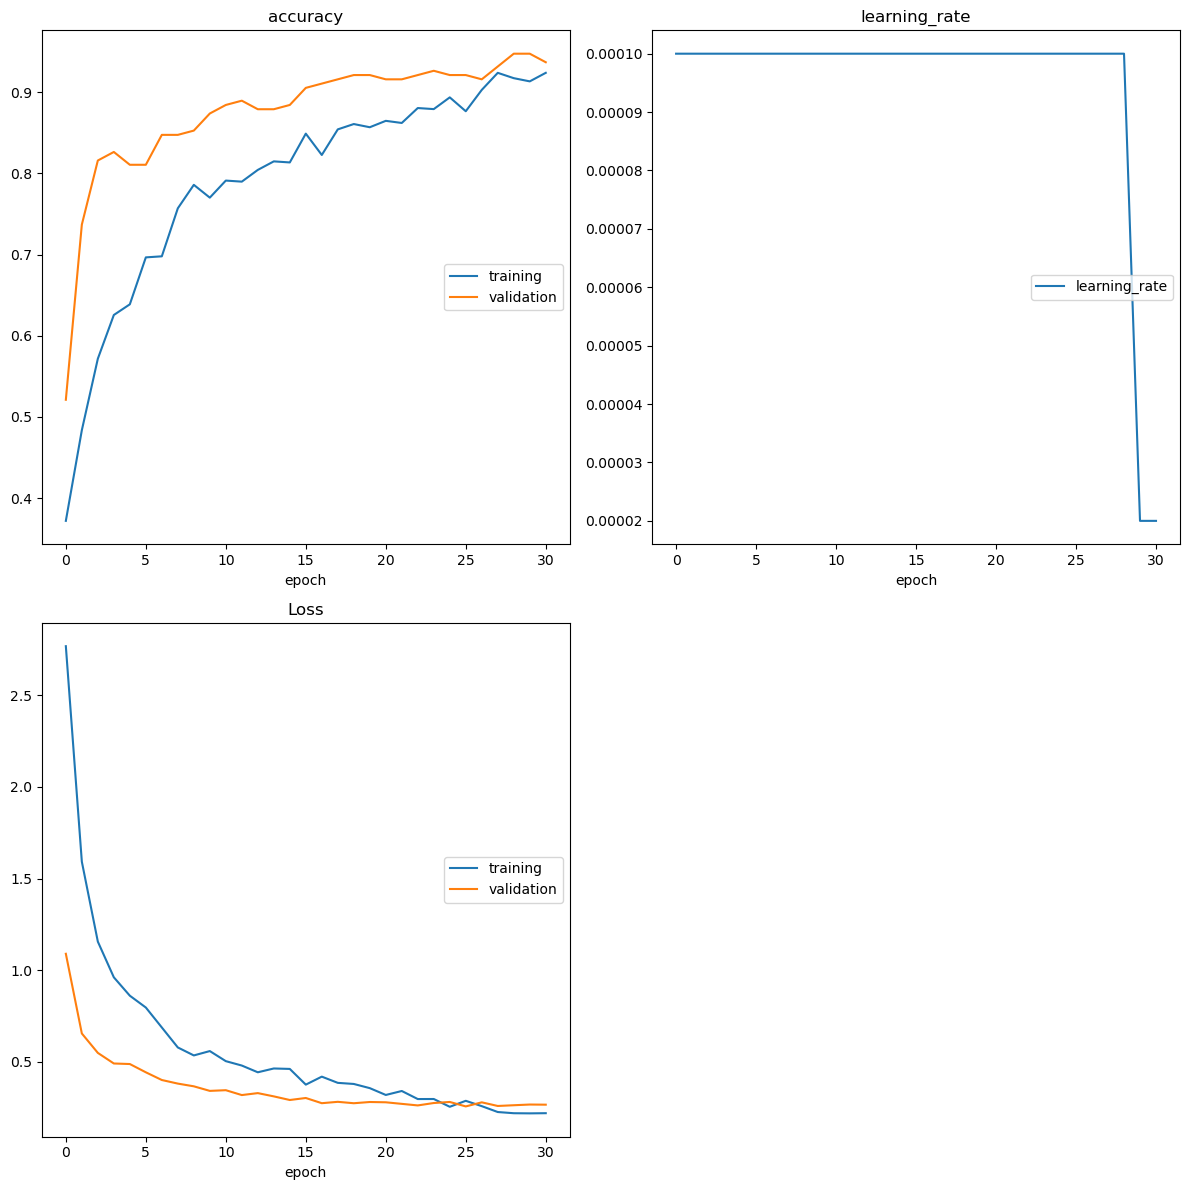

accuracy
	training         	 (min:    0.372, max:    0.924, cur:    0.924)
	validation       	 (min:    0.521, max:    0.947, cur:    0.937)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.219, max:    2.768, cur:    0.220)
	validation       	 (min:    0.256, max:    1.090, cur:    0.266)
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9195 - loss: 0.2273 - val_accuracy: 0.9368 - val_loss: 0.2660 - learning_rate: 2.0000e-05


In [17]:
# Start building the model by using the input from the pre-trained model
inputs = pretrained_model.input

# Apply data augmentation to the model's inputs
x = augment(inputs)

# Attach a dense layer with 128 nodes to the pre-trained model's output
x = Dense(128, activation='relu')(pretrained_model.output)

# Apply a dropout layer to prevent overfitting
x = Dropout(0.45)(x)

# Attach another dense layer with 256 nodes
x = Dense(256, activation='relu')(x)

# Apply another dropout layer
x = Dropout(0.45)(x)

# Attach the final classification layer with 3 nodes (for 3 categories)
outputs = Dense(3, activation='softmax')(x)

# Combine the defined architecture to build the complete model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer, categorical crossentropy as the loss function, and accuracy as the evaluation metric
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model using the training data with specified epochs, validation data, and callbacks
history = model.fit(
    train_images,                             # Training data
    steps_per_epoch=len(train_images) // batch_size_,        # Number of batches to consider as one epoch
    validation_data=val_images,               # Validation data
    validation_steps=len(val_images) // batch_size_,         # Number of batches to consider for validation
    epochs=150,                               # Total number of epochs to train the model
    callbacks=[                               # List of callbacks to be used during training
        early_stopping,                       # Stop training early if val_loss doesn't improve
        create_tensorboard_callback("training_logs", "bird_classification"), # Tensorboard logs callback
        checkpoint_callback,                  # Save model weights callback
        reduce_lr,
        PlotLossesKeras()                             # Reduce learning rate callback
    ]
)

# Evaluation

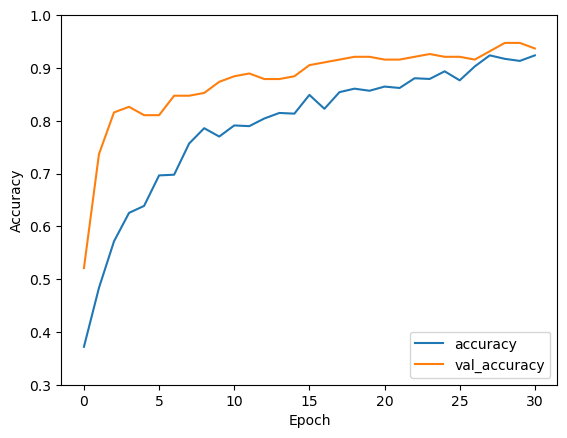

In [26]:
# plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')

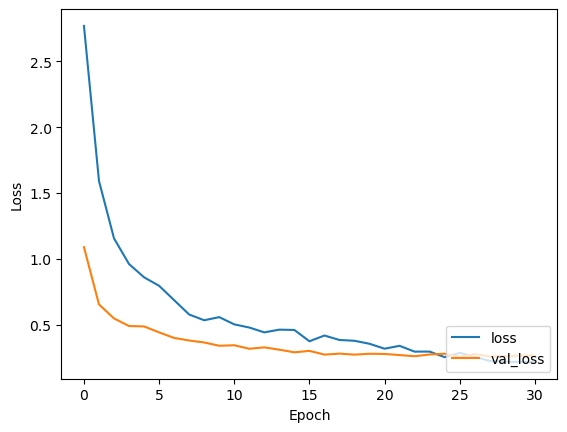

In [22]:
# plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(loc='lower right')

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.25094
Test Accuracy: 87.82%
